this first A1 level is working on the traditional idea to fixed moisture 40 to 60% for all crops




In [ ]:
from google.colab import files
uploaded = files.upload()


Saving data_core.csv to data_core (1).csv


In [ ]:
import math, random, json
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,4)

# Load dataset
df = pd.read_csv("data_core.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (8000, 9)


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26.0,52.0,38.0,Sandy,Maize,37,0,0,Urea
1,29.0,52.0,45.0,Loamy,Sugarcane,12,0,36,DAP
2,34.0,65.0,62.0,Black,Cotton,7,9,30,14-35-14
3,32.0,62.0,34.0,Red,Tobacco,22,0,20,28-28
4,28.0,54.0,46.0,Clayey,Paddy,35,0,0,Urea


In [ ]:
# Check columns
print(df.columns)

# Encode soil & crop types
df['SoilType_enc'] = df['Soil Type'].astype('category').cat.codes
df['CropType_enc'] = df['Crop Type'].astype('category').cat.codes

# Extract arrays for initialization
moisture_values = df['Moisture'].values
temp_values = df['Temparature'].values
hum_values = df['Humidity'].values

print("Moisture stats:", df['Moisture'].describe())


Index(['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type',
       'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name'],
      dtype='object')
Moisture stats: count    8000.000000
mean       43.580862
std        12.596156
min        20.000000
25%        33.967500
50%        42.250000
75%        52.950000
max        70.000000
Name: Moisture, dtype: float64


In [ ]:
class IrrigationEnvSimple:
    """
    LEVEL A (Discrete)
    State  = (moisture)
    Actions:
      0 = no irrigation
      1 = low
      2 = medium
      3 = high

    Goal Moisture: 40–60
    """

    def __init__(self, m_max=100, seed=None,
                 target_low=40, target_high=60,
                 moisture_values=None, temp_values=None, hum_values=None):

        self.m_max = m_max
        self.target_low = target_low
        self.target_high = target_high
        self.rng = np.random.RandomState(seed)

        self.moisture_values = moisture_values
        self.temp_values = temp_values
        self.hum_values = hum_values

        self.evap_base = 0.8
        self.action_effects = [0.0, 3.0, 6.0, 10.0]  # effect of actions

        self.reset()

    def reset(self, init_moisture=None):
        if init_moisture is not None:
            self.moisture = float(init_moisture)
        else:
            # Sample from real dataset moisture
            self.moisture = float(self.rng.choice(self.moisture_values))

        self.moisture = np.clip(self.moisture, 0, self.m_max)

        # sample temp & humidity for evap calculations
        self.temp = float(self.rng.choice(self.temp_values))
        self.hum = float(self.rng.choice(self.hum_values))

        return self._get_state()

    def _get_state(self):
        return (int(self.moisture),)

    def step(self, action):
        # irrigation effect
        effect = self.action_effects[action]

        # random rain chance
        rain = 0.0
        if self.rng.rand() < 0.05:
            rain = self.rng.uniform(2, 6)

        # evaporation depends on temp & humidity
        evap_mod = self.evap_base + (self.temp - 25) * 0.02 - (self.hum - 50) * 0.01
        evap = max(0, evap_mod + self.rng.normal(0,0.2))

        next_m = self.moisture + effect + rain - evap
        next_m += self.rng.normal(0,0.5)
        next_m = np.clip(next_m, 0, self.m_max)

        # reward
        reward = 0
        if next_m < self.target_low:
            reward -= 2
        elif next_m > self.target_high:
            reward -= 0.5
        else:
            reward += 1

        if action > 0:
            reward -= 0.2 * action

        self.moisture = next_m

        return self._get_state(), reward, False, {"moisture": self.moisture}


In [ ]:
def baseline_policy(state):
    m = state[0]
    return 2 if m < 40 else 0   # medium irrigation

def run_episode(env, policy, max_steps=40):
    s = env.reset()
    traj = []
    for _ in range(max_steps):
        a = policy(s)
        ns, r, done, info = env.step(a)
        traj.append((s,a,r,ns))
        s = ns
    return traj

def mc_policy_eval(env, policy, episodes=200, gamma=0.99):
    returns = defaultdict(list)
    V = defaultdict(float)

    for ep in range(episodes):
        traj = run_episode(env, policy)
        G = 0
        visited = set()

        for t in reversed(range(len(traj))):
            s,a,r,ns = traj[t]
            G = r + gamma * G
            if s not in visited:
                returns[s].append(G)
                V[s] = np.mean(returns[s])
                visited.add(s)
    return V

env = IrrigationEnvSimple(
    moisture_values=moisture_values,
    temp_values=temp_values,
    hum_values=hum_values,
    seed=0
)

V_mc = mc_policy_eval(env, baseline_policy)
print("Sample MC values:", list(V_mc.items())[:8])


Sample MC values: [((44,), np.float64(4.731878634828008)), ((45,), np.float64(7.4265527922097805)), ((39,), np.float64(7.341884598609511)), ((40,), np.float64(3.7391525473826204)), ((41,), np.float64(3.536301405673691)), ((42,), np.float64(3.7459669857864353)), ((43,), np.float64(3.7601729955338095)), ((47,), np.float64(12.058460895567903))]


In [ ]:
def td0_eval(env, policy, episodes=400, alpha=0.1, gamma=0.99):
    V = defaultdict(float)
    for ep in range(episodes):
        s = env.reset()
        for _ in range(40):
            a = policy(s)
            ns, r, done, info = env.step(a)
            V[s] += alpha * (r + gamma * V[ns] - V[s])
            s = ns
    return V

V_td0 = td0_eval(env, baseline_policy)
list(V_td0.items())[:8]


[((36,), 33.43646574330463),
 ((41,), 42.40638528397447),
 ((40,), 41.05188947572205),
 ((39,), 43.669955546010144),
 ((44,), 43.61687645039296),
 ((43,), 43.13018958967297),
 ((42,), 42.74102529625661),
 ((45,), 44.00265033258861)]

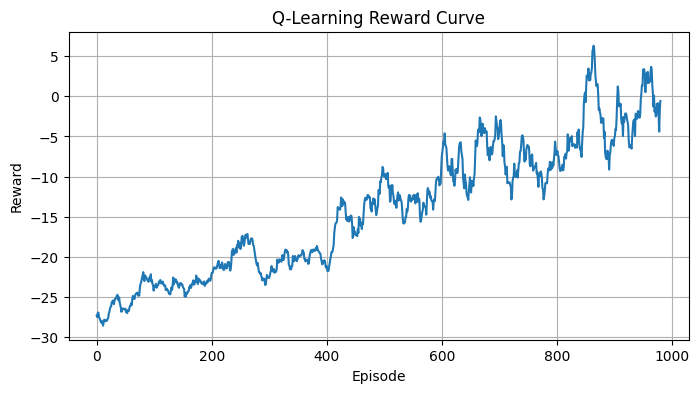

In [ ]:
def q_learning(env, episodes=1000, alpha=0.5, gamma=0.99,
               eps_start=0.9, eps_end=0.05, eps_decay=500):

    Q = defaultdict(lambda: np.zeros(4))
    rewards = []

    for ep in range(episodes):
        s = env.reset()
        total = 0

        eps = eps_end + (eps_start - eps_end) * math.exp(-ep / eps_decay)

        for _ in range(40):
            if random.random() < eps:
                a = random.randint(0,3)
            else:
                a = int(np.argmax(Q[s]))

            ns, r, done, info = env.step(a)

            Q[s][a] += alpha * (r + gamma * np.max(Q[ns]) - Q[s][a])
            s = ns
            total += r

        rewards.append(total)

    return Q, rewards

Q_tab, rewards = q_learning(env)

plt.plot(np.convolve(rewards, np.ones(20)/20, mode='valid'))
plt.title("Q-Learning Reward Curve")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


In [ ]:
def save_q(Q, filename="farmsmart_q_levelA.json"):
    data = {str(k): v.tolist() for k,v in Q.items()}
    with open(filename, "w") as f:
        json.dump(data, f, indent=2)
    print("Q-table saved as", filename)

save_q(Q_tab)


Q-table saved as farmsmart_q_levelA.json


This A2 level is advanced version that compute ideal moisture range based on crop type or soil type.

Different crops need different water → our RL agent will irrigate based on crop type.

This makes it suitable for real farms with multiple crops.

Matches the research direction of precision irrigation.

In [ ]:
import math, random, json, os
from collections import defaultdict
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,4)

# Load dataset
df = pd.read_csv("data_core.csv")
print("Loaded dataset shape:", df.shape)
display(df.head())


Loaded dataset shape: (8000, 9)


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26.0,52.0,38.0,Sandy,Maize,37,0,0,Urea
1,29.0,52.0,45.0,Loamy,Sugarcane,12,0,36,DAP
2,34.0,65.0,62.0,Black,Cotton,7,9,30,14-35-14
3,32.0,62.0,34.0,Red,Tobacco,22,0,20,28-28
4,28.0,54.0,46.0,Clayey,Paddy,35,0,0,Urea


In [ ]:
# We'll compute ideal moisture ranges using mean ± std (and clip to [0,100]).
#  choose percentiles instead if we prefer robust targets.

# Normalize column names if necessary
df.columns = [c.strip() for c in df.columns]

# Ensure moisture is numeric
df['Moisture'] = pd.to_numeric(df['Moisture'], errors='coerce')
df = df.dropna(subset=['Moisture'])

#Reinforcement Learning me gradients bohot noisy hote hain
#kyunki reward signal stable nahi hota.
#Adam un noisy gradients ko properly smooth karke stable updates deta hai.
# A2-2: per-crop targets
crop_stats = df.groupby('Crop Type')['Moisture'].agg(['mean','std','count']).reset_index()
crop_stats['target_low_crop']  = (crop_stats['mean'] - crop_stats['std']).clip(0,100)
crop_stats['target_high_crop'] = (crop_stats['mean'] + crop_stats['std']).clip(0,100)
print("Per-crop targets (sample):")
display(crop_stats.head(12))

# A2-3: per-(crop,soil) targets
cs_stats = df.groupby(['Crop Type','Soil Type'])['Moisture'].agg(['mean','std','count']).reset_index()
cs_stats['target_low_cs']  = (cs_stats['mean'] - cs_stats['std']).clip(0,100)
cs_stats['target_high_cs'] = (cs_stats['mean'] + cs_stats['std']).clip(0,100)
print("Per (crop,soil) targets (sample):")
display(cs_stats.head(12))

# Convert to lookup dicts for fast access
crop_target_lookup = {row['Crop Type']:(row['target_low_crop'], row['target_high_crop']) for _,row in crop_stats.iterrows()}
cs_target_lookup = {(row['Crop Type'], row['Soil Type']):(row['target_low_cs'], row['target_high_cs']) for _,row in cs_stats.iterrows()}

# For any missing pair we fallback to crop target then to global default
global_mean = df['Moisture'].mean()
global_std  = df['Moisture'].std()
global_low = float(max(0, global_mean - global_std))
global_high = float(min(100, global_mean + global_std))
print(f"Global default target: {global_low:.1f} - {global_high:.1f}")


Per-crop targets (sample):


,Crop Type,mean,std,count,target_low_crop,target_high_crop
0,Barley,43.483514,12.043758,703,31.439756,55.527271
1,Cotton,43.648989,12.758185,722,30.890804,56.407174
2,Ground Nuts,42.852254,12.581665,732,30.270589,55.433920
3,Maize,44.526348,12.929468,753,31.596880,57.455816
4,Millets,43.792813,12.710698,718,31.082115,56.503512
5,Oil seeds,43.859761,12.688233,711,31.171528,56.547994
6,Paddy,42.951686,12.560823,706,30.390863,55.512508
7,Pulses,43.016113,12.279928,728,30.736184,55.296041
8,Sugarcane,43.548938,12.953454,763,30.595485,56.502392
9,Tobacco,44.259582,12.462228,717,31.797354,56.721809


Per (crop,soil) targets (sample):


,Crop Type,Soil Type,mean,std,count,target_low_cs,target_high_cs
0,Barley,Black,44.006136,11.777071,132,32.229065,55.783207
1,Barley,Clayey,42.975397,11.379850,126,31.595546,54.355247
2,Barley,Loamy,43.532617,12.828220,149,30.704398,56.360837
3,Barley,Red,43.330759,12.573080,145,30.757679,55.903839
4,Barley,Sandy,43.548874,11.626734,151,31.922140,55.175608
5,Cotton,Black,43.063867,12.873536,150,30.190331,55.937403
6,Cotton,Clayey,43.933310,12.836944,145,31.096366,56.770255
7,Cotton,Loamy,43.324395,12.899733,157,30.424662,56.224128
8,Cotton,Red,44.784397,12.666426,141,32.117971,57.450823
9,Cotton,Sandy,43.163798,12.569580,129,30.594219,55.733378


Global default target: 31.0 - 56.2


In [ ]:
# Corrected IrrigationEnvDataDriven (use rng.randint instead of randrange)
class IrrigationEnvDataDriven:
    def __init__(self, df, crop_targets, cs_targets,
                 m_max=100, seed=None, evap_base=0.8,
                 action_effects=(0.0,3.0,6.0,10.0)):
        self.df = df.copy()
        self.crop_targets = crop_targets
        self.cs_targets = cs_targets
        self.m_max = m_max
        self.evap_base = evap_base
        self.action_effects = list(action_effects)
        self.rng = np.random.RandomState(seed)
        # prepare sampling pool (list of tuples)
        # ensure column names exist
        cols = ['Crop Type','Soil Type','Temparature','Humidity','Moisture']
        for c in cols:
            if c not in self.df.columns:
                raise ValueError(f"Column '{c}' missing from dataframe.")
        self.samples = self.df[cols].dropna().values.tolist()
        if len(self.samples) == 0:
            raise ValueError("No valid samples found in dataframe for sampling.")

        # prepare categorical ordering for encodings (stable across runs)
        self.crop_categories = list(self.df['Crop Type'].astype('category').cat.categories)
        self.soil_categories = list(self.df['Soil Type'].astype('category').cat.categories)

    def sample_plot(self):
        # safe index selection using numpy RandomState
        idx = int(self.rng.randint(0, len(self.samples)))
        row = self.samples[idx]
        # row may be array-like: unpack carefully
        crop = row[0]
        soil = row[1]
        temp = row[2]
        hum = row[3]
        moisture = row[4]
        return str(crop), str(soil), float(temp), float(hum), float(moisture)

    def get_target(self, crop, soil):
        # Prefer crop+soil targets, fallback to crop-only, fallback to global
        if (crop, soil) in self.cs_targets:
            return tuple(self.cs_targets[(crop,soil)])
        if crop in self.crop_targets:
            return tuple(self.crop_targets[crop])
        # fallback to global (global_low/global_high must be defined in your notebook)
        return (global_low, global_high)

    def reset(self, init=None):
        # sample a plot config
        self.crop, self.soil, self.temp, self.hum, self.moisture = self.sample_plot()
        if init is not None:
            # optionally set moisture explicitly
            self.moisture = float(init)
        self.t = 0
        return self._get_state()

    def _get_state(self):
        # state = (discrete moisture, crop_enc, soil_enc)
        # encode crop and soil as simple integer codes (consistent order)
        try:
            crop_enc = int(self.crop_categories.index(self.crop))
        except Exception:
            # if unseen, fallback to 0
            crop_enc = 0
        try:
            soil_enc = int(self.soil_categories.index(self.soil))
        except Exception:
            soil_enc = 0
        return (int(round(self.moisture)), crop_enc, soil_enc)

    def step(self, action):
        # action ∈ {0,1,2,3}
        action = int(action)
        effect = self.action_effects[action]
        # small rain chance
        rain = 0.0
        if self.rng.rand() < 0.06:
            rain = float(self.rng.uniform(2,6))
        evap_mod = self.evap_base + (self.temp - 25)*0.02 - (self.hum - 50)*0.01
        evap = float(max(0, evap_mod + self.rng.normal(0,0.2)))
        next_m = float(self.moisture + effect + rain - evap + float(self.rng.normal(0,0.5)))
        next_m = float(np.clip(next_m, 0, self.m_max))

        # determine target (using crop+soil)
        low, high = self.get_target(self.crop, self.soil)

        # reward: keep in (low,high) and penalize water usage
        reward = 0.0
        if next_m < low:
            reward -= 2.0
        elif next_m > high:
            reward -= 0.5
        else:
            reward += 1.0
        if action > 0:
            reward -= 0.2 * action

        self.moisture = next_m
        self.t += 1
        done = False
        info = {'moisture':self.moisture, 'crop':self.crop, 'soil':self.soil, 'target_low':low, 'target_high':high}
        return self._get_state(), reward, done, info

# Quick test of the corrected class
env = IrrigationEnvDataDriven(df, crop_target_lookup, cs_target_lookup, seed=1)
print("reset state:", env.reset())
print("step example:", env.step(2))
print("target for this plot:", env.get_target(env.crop, env.soil))


reset state: (26, 4, 1)
step example: ((31, 4, 1), 0.6, False, {'moisture': 30.619729415333236, 'crop': 'Millets', 'soil': 'Clayey', 'target_low': 30.362174635252337, 'target_high': 57.72883985750128})
target for this plot: (30.362174635252337, 57.72883985750128)


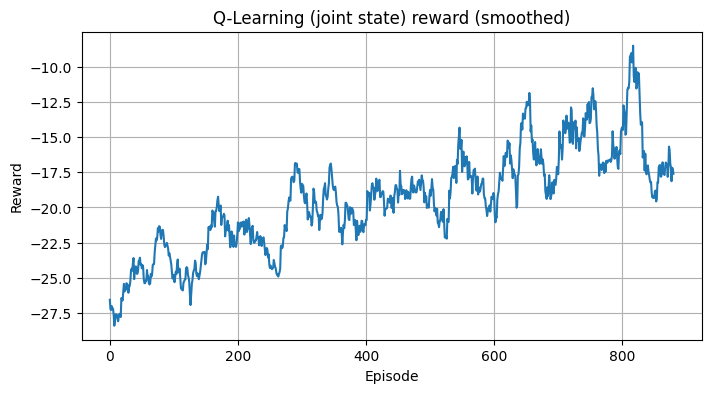

In [ ]:
# We will discretize only moisture (0..m_max), crop_enc & soil_enc are small codes.
# Q table keyed by state tuple.

def q_learning_joint(env, episodes=1200, alpha=0.5, gamma=0.99,
                     eps_start=0.9, eps_end=0.05, eps_decay=700, max_steps=40, seed=None):
    if seed is not None:
        random.seed(seed); np.random.seed(seed)
    n_actions = 4
    Q = defaultdict(lambda: np.zeros(n_actions))
    rewards = []
    per_crop_rewards = defaultdict(list)

    for ep in range(episodes):
        s = env.reset()
        total = 0.0
        eps = eps_end + (eps_start-eps_end) * math.exp(-ep/eps_decay)

        for t in range(max_steps):
            if random.random() < eps:
                a = random.randint(0,n_actions-1)
            else:
                a = int(np.argmax(Q[s]))
            ns, r, done, info = env.step(a)
            Q[s][a] += alpha * (r + gamma * np.max(Q[ns]) - Q[s][a])
            s = ns
            total += r

        rewards.append(total)
        # record by crop of this episode (last info)
        per_crop_rewards[env.crop].append(total)

    return Q, rewards, per_crop_rewards

env = IrrigationEnvDataDriven(df, crop_target_lookup, cs_target_lookup, seed=2)
Q_joint, rewards_joint, per_crop_rewards = q_learning_joint(env, episodes=900, seed=0)

# plot learning curve
plt.plot(np.convolve(rewards_joint, np.ones(20)/20, mode='valid'))
plt.title("Q-Learning (joint state) reward (smoothed)"); plt.xlabel("Episode"); plt.ylabel("Reward"); plt.grid(True); plt.show()


Average episode reward per crop (sample):
Tobacco: -18.925
Pulses: -19.857
Wheat: -19.663
Ground Nuts: -19.715
Barley: -18.380
Cotton: -19.048
Maize: -19.270
Oil seeds: -18.863
Paddy: -20.356
Sugarcane: -20.733
Millets: -19.509
Sample greedy trajectory (crop,soil,moisture_before,action,moist_after,low,high,reward):
('Millets', 'Clayey', 70, 1, 77.39, 30.4, 57.7, -0.7)
('Millets', 'Clayey', 77, 0, 76.23, 30.4, 57.7, -0.5)
('Millets', 'Clayey', 76, 3, 85.37, 30.4, 57.7, -1.1)
('Millets', 'Clayey', 85, 0, 84.69, 30.4, 57.7, -0.5)
('Millets', 'Clayey', 85, 0, 85.65, 30.4, 57.7, -0.5)
('Millets', 'Clayey', 86, 0, 84.86, 30.4, 57.7, -0.5)
('Millets', 'Clayey', 85, 0, 84.22, 30.4, 57.7, -0.5)
('Millets', 'Clayey', 84, 3, 93.4, 30.4, 57.7, -1.1)
('Millets', 'Clayey', 93, 1, 95.97, 30.4, 57.7, -0.7)
('Millets', 'Clayey', 96, 0, 94.28, 30.4, 57.7, -0.5)
('Millets', 'Clayey', 94, 2, 99.81, 30.4, 57.7, -0.9)
('Millets', 'Clayey', 100, 1, 100.0, 30.4, 57.7, -0.7)


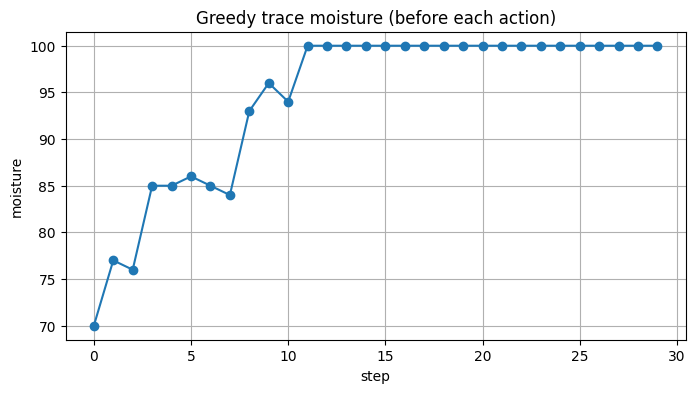

In [ ]:
# Average reward per crop
avg_crop = {crop: np.mean(vals) for crop,vals in per_crop_rewards.items()}
print("Average episode reward per crop (sample):")
for k,v in list(avg_crop.items())[:12]:
    print(f"{k}: {v:.3f}")

# Test greedy policy for a few sampled plots
def greedy_policy(Q):
    return lambda s: int(np.argmax(Q[s]))

policy_g = greedy_policy(Q_joint)

def run_test_episodes(env, policy, n=6, steps=40):
    traces = []
    for i in range(n):
        s = env.reset()
        trace = []
        for _ in range(steps):
            a = policy(s)
            ns, r, done, info = env.step(a)
            trace.append((info['crop'], info['soil'], s[0], a, round(info['moisture'],2), round(info['target_low'],1), round(info['target_high'],1), r))
            s = ns
        traces.append(trace)
    return traces

env_test = IrrigationEnvDataDriven(df, crop_target_lookup, cs_target_lookup, seed=5)
traces = run_test_episodes(env_test, policy_g, n=4, steps=30)

# print first trace (first 12 steps) for readability
print("Sample greedy trajectory (crop,soil,moisture_before,action,moist_after,low,high,reward):")
for row in traces[0][:12]:
    print(row)

# plot moisture for first trace
plt.plot([r[2] for r in traces[0]], marker='o')
plt.title("Greedy trace moisture (before each action)"); plt.xlabel("step"); plt.ylabel("moisture"); plt.grid(True); plt.show()


In [ ]:
# Save Q-table
def save_q(Q, path="farmsmart_q_A2.json"):
    serial = {str(k): v.tolist() for k,v in Q.items()}
    with open(path, "w") as f: json.dump(serial, f, indent=2)
    print("Saved Q-table to", path)

save_q(Q_joint, "/content/farmsmart_q_A2.json")

# Save targets lookup
with open("/content/targets_crop.json","w") as f:
    json.dump({k: list(v) for k,v in crop_target_lookup.items()}, f, indent=2)
with open("/content/targets_crop_soil.json","w") as f:
    json.dump({str(k): list(v) for k,v in cs_target_lookup.items()}, f, indent=2)
print("Saved target lookups.")


Saved Q-table to /content/farmsmart_q_A2.json
Saved target lookups.



### Checking requirements for: Maize ###
Ideal Moisture Range: 31.6 – 57.5
Current Moisture: 60
Irrigation Needed: NO — Soil Already WET
Recommended Fertilizer: 14-35-14


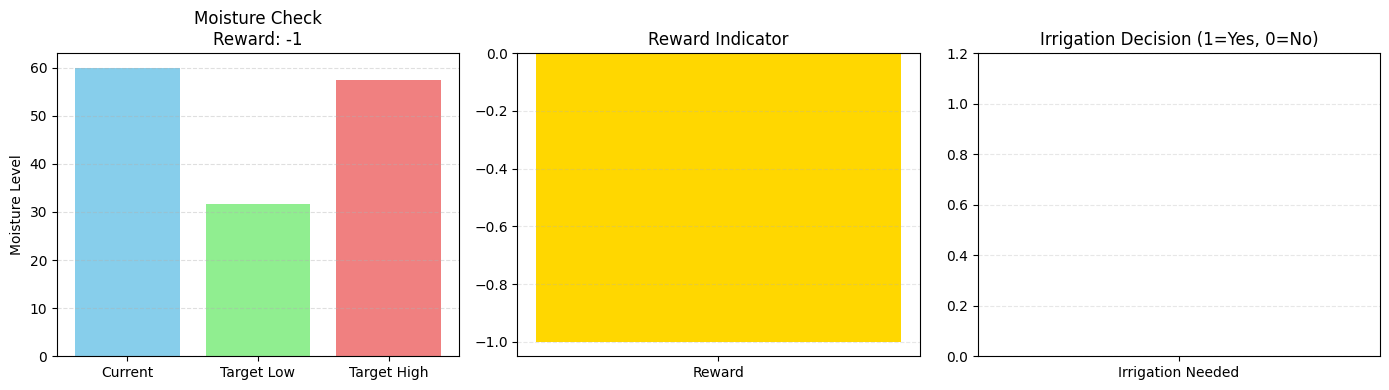

{'crop': 'Maize',
 'moisture_low': np.float64(31.596880347871064),
 'moisture_high': np.float64(57.45581553526307),
 'current_moisture': 60,
 'irrigation_needed': False,
 'recommended_fertilizer': '14-35-14',
 'reward': -1}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---------------------- MAIN CHECK FUNCTION ----------------------
def check_crop_requirements(crop_name, current_moisture):
    crop_name = crop_name.strip().title()

    df_crop = df[df['Crop Type'].str.title() == crop_name]

    if df_crop.empty:
        print(f"❌ Crop not found: {crop_name}")
        return

    print(f"\n### Checking requirements for: {crop_name} ###")

    # Moisture target calculation
    mean_m = df_crop['Moisture'].mean()
    std_m = df_crop['Moisture'].std()
    low_target = max(0, mean_m - std_m)
    high_target = min(100, mean_m + std_m)

    print(f"Ideal Moisture Range: {low_target:.1f} – {high_target:.1f}")
    print(f"Current Moisture: {current_moisture}")

    # Irrigation + reward
    if current_moisture < low_target:
        irrigation_needed = True
        reward = -2
        decision = "YES — Soil Moisture LOW"
    elif current_moisture > high_target:
        irrigation_needed = False
        reward = -1
        decision = "NO — Soil Already WET"
    else:
        irrigation_needed = False
        reward = 1
        decision = "NO — Moisture OPTIMAL"

    print("Irrigation Needed:", decision)

    # Fertilizer recommendation
    common_fert = df_crop["Fertilizer Name"].value_counts().idxmax()
    print(f"Recommended Fertilizer: {common_fert}")

    # ---------------------- Dashboard Plot ----------------------
    plt.figure(figsize=(14,4))

    # 1 Moisture Bar Comparison
    plt.subplot(1, 3, 1)
    labels = ["Current", "Target Low", "Target High"]
    values = [current_moisture, low_target, high_target]
    colors = ["skyblue", "lightgreen", "lightcoral"]
    plt.bar(labels, values, color=colors)
    plt.title(f"Moisture Check\nReward: {reward}")
    plt.ylabel("Moisture Level")
    plt.grid(axis='y', linestyle='--', alpha=0.4)

    # 2 Rewards Indicator
    plt.subplot(1, 3, 2)
    plt.bar(["Reward"], [reward], color="gold")
    plt.title("Reward Indicator")
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # 3 Irrigation Decision
    plt.subplot(1, 3, 3)
    plt.bar(["Irrigation Needed"], [1 if irrigation_needed else 0],
            color="green" if irrigation_needed else "red")
    plt.title("Irrigation Decision (1=Yes, 0=No)")
    plt.ylim(0, 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return dictionary
    return {
        "crop": crop_name,
        "moisture_low": low_target,
        "moisture_high": high_target,
        "current_moisture": current_moisture,
        "irrigation_needed": irrigation_needed,
        "recommended_fertilizer": common_fert,
        "reward": reward
    }



# ---------------------- RUN ALL ----------------------
# Example:
# check_crop_requirements("Paddy", 35)
# plot_multiple_crop_moisture()
# plot_moisture_vs_temperature()
# plot_fertilizer_usage()
check_crop_requirements("Maize", 20)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving data_core.csv to data_core (2).csv


In [ ]:
import pandas as pd

df = pd.read_csv("data_core.csv")
df.head()


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26.0,52.0,38.0,Sandy,Maize,37,0,0,Urea
1,29.0,52.0,45.0,Loamy,Sugarcane,12,0,36,DAP
2,34.0,65.0,62.0,Black,Cotton,7,9,30,14-35-14
3,32.0,62.0,34.0,Red,Tobacco,22,0,20,28-28
4,28.0,54.0,46.0,Clayey,Paddy,35,0,0,Urea


In [ ]:
df = pd.read_csv("/content/data_core.csv")
df.head()


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26.0,52.0,38.0,Sandy,Maize,37,0,0,Urea
1,29.0,52.0,45.0,Loamy,Sugarcane,12,0,36,DAP
2,34.0,65.0,62.0,Black,Cotton,7,9,30,14-35-14
3,32.0,62.0,34.0,Red,Tobacco,22,0,20,28-28
4,28.0,54.0,46.0,Clayey,Paddy,35,0,0,Urea


In [ ]:

#           A3 - DQN Smart Irrigation
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque


# 1. LOAD DATASET
df = pd.read_csv("/content/data_core.csv")
print("Dataset Loaded:")
print(df.head())

# 2. CREATE DATA-DRIVEN TARGETS
# Crop-wise targets: mean ± std making data driven target
crop_stats = df.groupby("Crop Type")["Moisture"].agg(["mean","std"])
crop_target_lookup = {
    c: (m - s, m + s) for c, (m, s) in crop_stats.iterrows()
}

# Crop-Soil wise targets
cs_stats = df.groupby(["Crop Type","Soil Type"])["Moisture"].agg(["mean","std"])
cs_target_lookup = {
    (c, s): (m - std, m + std) for (c, s), (m, std) in cs_stats.iterrows()
}


# 3. ENVIRONMENT CLASS (A2/A3)
#Init me targets, action effects, and sample pool prepare karte hain
class IrrigationEnvDataDriven:
    def __init__(self, df, crop_targets, cs_targets,#for reward calculate data +target lookups
                 m_max=100, seed=None, evap_base=0.8,#moisture cap 100
                 action_effects=(0.0,3.0,6.0,10.0)): #action ka moisture increse effect (No/Low/Med/High).

        self.df = df.copy()
        self.crop_targets = crop_targets
        self.cs_targets = cs_targets
        self.m_max = m_max
        self.evap_base = evap_base
        self.action_effects = list(action_effects)
        self.rng = np.random.RandomState(seed) #reproducible randomness.

        cols = ['Crop Type','Soil Type','Temparature','Humidity','Moisture']
        self.samples = self.df[cols].dropna().values.tolist()#sample rows list from df (crop, soil, temp, hum, moisture) — used for sampling random plot.

        if len(self.samples) == 0:
            raise ValueError("No valid samples found in dataframe.")

        # store categories for encoding categories list for encoding.
        self.crop_categories = list(self.df['Crop Type'].astype('category').cat.categories)
        self.soil_categories = list(self.df['Soil Type'].astype('category').cat.categories)


    def sample_plot(self):
        idx = int(self.rng.randint(0, len(self.samples)))
        crop, soil, temp, hum, moisture = self.samples[idx]
        return str(crop), str(soil), float(temp), float(hum), float(moisture)

#Check (crop, soil) in cs_targets → return that; else if crop in crop_targets → return crop target; else fallback (30,60).

    def get_target(self, crop, soil):
        if (crop, soil) in self.cs_targets:
            return self.cs_targets[(crop, soil)]
        if crop in self.crop_targets:
            return self.crop_targets[crop]
        return (30, 60)  # fallback

#Environment ko random plot se initialise karta hai; returns initial state vector and info dict with starting moisture.
    def reset(self):
        self.crop, self.soil, self.temp, self.hum, self.moisture = self.sample_plot()
        return self._get_state(), {"moisture": self.moisture}

#State ko numeric vector me convert karta hai — neural network ke liye float32 array. Crop & soil encodings are integers but kept as floats.
    def _get_state(self):
        crop_enc = self.crop_categories.index(self.crop)
        soil_enc = self.soil_categories.index(self.soil)
        return np.array([
            self.moisture,
            self.temp,
            self.hum,
            crop_enc,
            soil_enc
        ], dtype=np.float32)

    def step(self, action):
        action = int(action)

        effect = self.action_effects[action]#irrigation amount added.

        # random rain
        rain = 0
        if self.rng.rand() < 0.06: #random: with 6% prob add 2–6 moisture to simulate rain.
            rain = float(self.rng.uniform(2, 6))

        evap_mod = self.evap_base + (self.temp - 25)*0.02 - (self.hum - 50)*0.01 #evaporation base adjusted by temp & humidity.
        evap = max(0, evap_mod + self.rng.normal(0, 0.2)) #ensure non-negative.

        next_m = self.moisture + effect + rain - evap + float(self.rng.normal(0, 0.5)) #and clip 0–m_max.
        next_m = float(np.clip(next_m, 0, self.m_max))

        # crop-soil target
        low, high = self.get_target(self.crop, self.soil)#determine target.

        reward = 0
        if next_m < low:
            reward -= 2 #too dry
        elif next_m > high:
            reward -= 0.5 #too wet
        else:
            reward += 1 #ideal

        reward -= 0.2 * action #penalize water usage

        self.moisture = next_m
        done = False

        info = {"moisture": next_m}

        return self._get_state(), reward, done, info

 #Moisture evolves: irrigation + rain − evaporation ± noise.”
#Reward encourages staying inside target and penalizes unnecessary water.”




# 4. DQN NETWORK

#Small MLP: 5 → 64 → 64 → 4.
#Input = 5 features (state); Output = 4 Q-values (for each action).


class DQN(nn.Module):
    def __init__(self, input_dim=5, output_dim=4):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)



# 5. REPLAY BUFFER
#deque stores transitions up to size.

#sample returns random batch; uses random.sample → returns arrays for states, actions, rewards, next_states, dones.


class ReplayBuffer:
    def __init__(self, size=50000):
        self.buffer = deque(maxlen=size)

    def add(self, exp):
        self.buffer.append(exp)

    def sample(self, batch_size=32):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


# -------------------------------
# 6. DQN AGENT
# Device selection GPU/CPU.



class DQNAgent:
    def __init__(self, state_dim=5, action_dim=4):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.action_dim = action_dim
        self.online = DQN(state_dim, action_dim).to(self.device)
        self.target = DQN(state_dim, action_dim).to(self.device)
        self.target.load_state_dict(self.online.state_dict())

        self.optim = optim.Adam(self.online.parameters(), lr=0.001)
        self.gamma = 0.99
        self.epsilon = 1.0       # Exploration
        self.eps_min = 0.05
        self.eps_decay = 0.995
        self.memory = ReplayBuffer()


        #ε-greedy: with prob ε choose random action else use online network to pick argmax Q.


    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)

        s = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        qvals = self.online(s)
        return torch.argmax(qvals).item()

    def train_step(self, batch_size=32):
        if len(self.memory) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)

        states = torch.FloatTensor(states).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        q_values = self.online(states) #shape (batch, action_dim).
        next_q = self.target(next_states).max(1)[0] #max over actions from target network

        target_q = rewards + (1 - dones) * self.gamma * next_q #TD target; dones used to zero future contribution for terminal states.

        q_pred = q_values.gather(1, actions.unsqueeze(1)).squeeze()#pick predicted Q for actual taken action.

        loss = nn.MSELoss()(q_pred, target_q.detach()) #compute loss; detach() so target not backproped into target network.

#Backprop & optimizer step.
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

        # reduce epsilon
        self.epsilon = max(self.eps_min, self.epsilon * self.eps_decay)




# -------------------------------
# 7. CREATE ENV + AGENT


env = IrrigationEnvDataDriven(df, crop_target_lookup, cs_target_lookup, seed=42)
agent = DQNAgent(state_dim=5, action_dim=4)


# -------------------------------
# 8. TRAINING LOOP
# -------------------------------

episodes = 200

for ep in range(episodes):
    state, info = env.reset()
    total_reward = 0

    for t in range(100):  # steps per episode how many time-steps we simulate per episode.
        action = agent.act(state) #choose action via ε-greedy.
        next_state, reward, done, info = env.step(action) #environment simulates outcome and returns reward.

        agent.memory.add((state, action, reward, next_state, done)) #store experience.
        agent.train_step(batch_size=32)

        state = next_state
        total_reward += reward

    # update target network every 10 episodes
    if ep % 10 == 0:
        agent.target.load_state_dict(agent.online.state_dict())

    print(f"Episode {ep}, Total Reward = {total_reward:.2f}, Epsilon = {agent.epsilon:.3f}")

print("\nTraining Completed!")#After episode, every 10 episodes update target network weights to current online weights. This is a hard update every 10 episodes.

#Print logging: shows episode number, total reward and current epsilon.

#After the loop, Training Completed! indicates loop finished

#viva line:Training logs show learning curve: reward improves, epsilon decays — agent learns irrigation policy.”


Dataset Loaded:
   Temparature  Humidity  Moisture Soil Type  Crop Type  Nitrogen  Potassium  \
0         26.0      52.0      38.0     Sandy      Maize        37          0   
1         29.0      52.0      45.0     Loamy  Sugarcane        12          0   
2         34.0      65.0      62.0     Black     Cotton         7          9   
3         32.0      62.0      34.0       Red    Tobacco        22          0   
4         28.0      54.0      46.0    Clayey      Paddy        35          0   

   Phosphorous Fertilizer Name  
0            0            Urea  
1           36             DAP  
2           30        14-35-14  
3           20           28-28  
4            0            Urea  
Episode 0, Total Reward = -74.10, Epsilon = 0.708
Episode 1, Total Reward = -51.50, Epsilon = 0.429
Episode 2, Total Reward = -64.00, Epsilon = 0.260
Episode 3, Total Reward = -61.10, Epsilon = 0.157
Episode 4, Total Reward = 36.60, Epsilon = 0.095
Episode 5, Total Reward = -56.00, Epsilon = 0.058
Episod